In [3]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.morphology import binary_dilation, disk
from skimage.restoration import inpaint
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage.morphology import binary_dilation, disk
from skimage.restoration import inpaint
from scipy.ndimage import convolve
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.morphology import binary_dilation
from skimage.restoration import inpaint

In [2]:
pip install opencv-python

     |████████████████████████████████| 54.7 MB 883 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


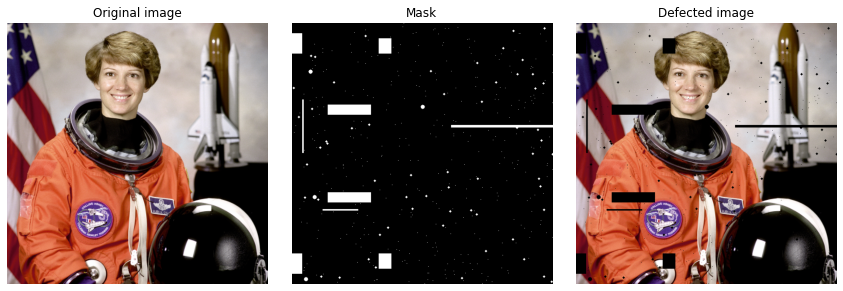

In [4]:


# Load the astronaut sample image
image_orig = data.astronaut()

# Create a mask with six block defect regions
mask = np.zeros(image_orig.shape[:-1], dtype=bool)
mask[20:60, 0:20] = 1
mask[160:180, 70:155] = 1
mask[30:60, 170:195] = 1
mask[-60:-30, 170:195] = 1
mask[-180:-160, 70:155] = 1
mask[-60:-20, 0:20] = 1

# Add a few long, narrow defects
mask[200:205, -200:] = 1
mask[150:255, 20:23] = 1
mask[365:368, 60:130] = 1

# Add randomly positioned small point-like defects
rstate = np.random.default_rng(0)
for radius in [0, 2, 4]:
    # larger defects are less common
    thresh = 3 + 0.25 * radius  # make larger defects less common
    tmp_mask = rstate.standard_normal(image_orig.shape[:-1]) > thresh
    if radius > 0:
        tmp_mask = binary_dilation(tmp_mask, disk(radius, dtype=bool))
    mask[tmp_mask] = 1

# Apply defect mask to the image over the same region in each color channel
image_defect = image_orig * ~mask[..., np.newaxis]

# Display the original image, mask, and defected image
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
ax = axes.ravel()

ax[0].set_title('Original image')
ax[0].imshow(image_orig)

ax[1].set_title('Mask')
ax[1].imshow(mask, cmap=plt.cm.gray)

ax[2].set_title('Defected image')
ax[2].imshow(image_defect)

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()


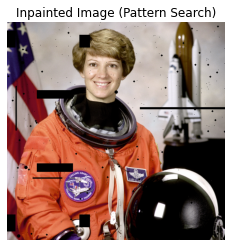

In [5]:
def pattern_search(input_image, mask, patch_size=11, search_size=21):
    h, w = input_image.shape[:2]
    output_image = np.copy(input_image)

    # Iterate through each missing pixel in the mask
    for i in range(h):
        for j in range(w):
            if mask[i, j]:
                # Define the search window
                i_min, i_max = max(0, i - search_size // 2), min(h, i + search_size // 2 + 1)
                j_min, j_max = max(0, j - search_size // 2), min(w, j + search_size // 2 + 1)

                # Extract the patch around the missing pixel
                target_patch = input_image[i - patch_size // 2:i + patch_size // 2 + 1,
                                           j - patch_size // 2:j + patch_size // 2 + 1]

                # Initialize variables for SSD and best match
                best_ssd = float('inf')
                best_match = None

                # Search for the best match in the search window
                for x in range(i_min, i_max - patch_size + 1):
                    for y in range(j_min, j_max - patch_size + 1):
                        if not mask[x:x + patch_size, y:y + patch_size].any():
                            search_patch = input_image[x:x + patch_size, y:y + patch_size]
                            ssd = np.sum((target_patch - search_patch) ** 2)

                            # Update best match if found
                            if ssd < best_ssd:
                                best_ssd = ssd
                                best_match = (x, y)

                # Check if a valid match is found
                if best_match is not None:
                    # Fill the missing pixel with the best match
                    output_image[i, j] = input_image[best_match[0] + patch_size // 2, best_match[1] + patch_size // 2]

    return output_image

# Apply pattern search to inpaint the image
inpainted_image_pattern_search = pattern_search(image_defect, mask)

# Display the inpainted image using pattern search
plt.figure()
plt.title('Inpainted Image (Pattern Search)')
plt.imshow(inpainted_image_pattern_search)
plt.axis('off')
plt.show()
